In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
import cvxpy as cp
import sklearn

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
import lcurve_functions as lc

from controlsair import AlgControls, AirProperties, load_cfg, sph2cart, cart2sph
from sources import Source
from receivers import Receiver
from field_pistonbaffle import PistonOnBaffle
from utils_insitu import plot_3d_polar, plot_3d_polar2, pre_balloon
from decomposition_ev import form_kz, DecompositionEv
from decomposition_ev_ig import DecompositionEv2

plt.rcParams.update({'font.size': 12})
#%matplotlib notebook

C:\Users\Cliente\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Cliente\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Cliente\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


# Ondas planas (a solução completa)

A equação de Helmholtz é dada por

\begin{equation}
\nabla \tilde{p}(\textbf{r},\text{j}\omega) + k_0^2 \ \tilde{p}(\textbf{r},\text{j}\omega) = 0
\end{equation}
em que $\tilde{p}(\text{j}\omega)$ é a amplitude complexa em estado estacionário com frequência $\omega$. Por campo em estado estacionário referimo-nos a trasformada de Fourier de um fenômeno temporal:

\begin{equation}
p(\textbf{r}, t) \xrightarrow{\mathscr{F}} \tilde{p}(\textbf{r}, \text{j} \omega)
\end{equation}

Se considerarmos apenas **uma** onda plana num campo acústico, a solução da equação de Helmholtz é

\begin{equation}
\tilde{p}(\textbf{r},\text{j}\omega) = A(\omega) \ \text{e}^{-\text{j}(\textbf{k} \cdot \textbf{r})} = A(\omega) \ \text{e}^{-\text{j}(k_x x + k_y y + k_z z)}
\end{equation}

e a velocidade de partícula é $\textbf{u} = (u_x, u_y, u_z)$, com componentes dadas por

\begin{equation}
u_{\cdot} = \frac{1}{\rho_0 c_0}\frac{k_{\cdot}}{k_0}A(\omega) \ \text{e}^{-\text{j}(k_x x + k_y y + k_z z)}
\end{equation}

A solução da onda plana, satisfaz a equação de Helmholtz se

\begin{equation}
k_{0}^{2} = k_{x}^{2}+k_{y}^{2}+k_{z}^{2}
\end{equation}

E já que $k_0 = \omega/c_0$ [rad/m] é uma constante, as três componentes do número de onda $(k_x, k_y, k_z)$ não são independentes uma da outra. Podemos escolher **duas variáveis independentes** (e.g. $k_x$ e $k_y$) e automaticamente $k_z$ será dependente, a saber

\begin{equation}
k_{z} = \pm \sqrt{k_{0}^{2}-(k_{x}^{2}+k_{y}^{2})} 
\end{equation}

- Não há nada que impeça $k_{x}^{2}+k_{y}^{2} > k_{0}^{2}$, forçando o argumento da raíz para um **número negativo**, o valor da raiz para um **número complexo**, o que resulta numa **função exponencial decrescente** em $z$ (uma **onda evanescente**).

- Também há o caso em que $k_{x}^{2}+k_{y}^{2} \leq k_{0}^{2}$, forçando o argumento da raíz para um número $\geq 0$, o que resulta numa **função exponencial oscilatória** em todas as direções (uma **onda plana propagante**). 

No caso da **onda plana propagante**, note que $\left\|\textbf{k}\right\|_{2}^{2} = \textbf{k} \cdot \textbf{k} = k_{x}^{2}+k_{y}^{2}+k_{z}^{2} = k_{0}^{2}$. Assim a norma $\ell_2$, $\textbf{k}$, é igual ao número de onda $k_0$ (com o qual estamos mais acostumados). 

Assim, podemos separar o vetor número de onda em duas partes:

- As componentes associadas as ondas planas **propagante**s: $k_{x}^{2}+k_{y}^{2} \leq k_{0}^{2}$
- As componentes associadas as ondas planas **evanescentes**: $k_{x}^{2}+k_{y}^{2} > k_{0}^{2}$




## Observe:

- As **variáveis independentes** do espectro de número de onda são $k_{x}$ e $k_{y}$. 

- $k_{x}^{2}+k_{y}^{2} = k_{0}^{2}$ é a equação de uma **circunferência** de raio $k_0$. 

- A circunferência é chamada de "círculo de radiação". Todas as componentes dentro dela serão **ondas planas propagantes** que conseguem transportar energia acústica para o campo distante. Todas as componentes fora dela serão **ondas planas evanescentes**, que decaem no campo próximo da fonte e não chegam ao campo distante.

Assim, podemos reescrever $k_z$ da seguinte forma:

\begin{equation}
k_z = \begin{cases} \sqrt{k_0^2-(k_{x}^{2}+k_{y}^{2})}, & \mbox{se  }  k_{x}^{2}+k_{y}^{2} \leq k_0^2, & \mbox{(dentro da circunferência)} \\ -\text{j} \sqrt{(k_{x}^{2}+k_{y}^{2})-k_0^2}, & \mbox{se }  k_{x}^{2}+k_{y}^{2} > k_0^2, & \mbox{(fora da circunferência)} \end{cases},
\end{equation}

Vamos investigar os casos de ondas planas propagantes e evanescentes - o que muda fisicamente em cada uma delas?

# Ondas planas propagantes

Acontecem para 

\begin{equation}
k_z = \sqrt{k_0^2-(k_{x}^{2}+k_{y}^{2})}, \ \ \ \ \mbox{se} \ \ \ \   k_{x}^{2}+k_{y}^{2} \leq k_0^2
\end{equation}

As coordenadas de $\textbf{k}$ caem **(dentro do circulo de radiação)**.

Vamos investigar ondas planas propagantes com diferentes $k_x$ e $k_y$. Como as ondas planas são propagantes, elas podem ser expressas em coordenadas esféricas com $\theta$ e $\phi$ sendo os ângulos de elevação (N-S) e azimute (E-W)

- $k_x = k_0 \ \text{cos}(\phi) \ \text{sin}(\theta)$
- $k_y = k_0 \ \text{sin}(\phi) \ \text{sin}(\theta)$

Com a solução da Equação de Helholtz dada por

\begin{equation}
\tilde{p} = A(\omega) \ \text{e}^{-\text{j}(k_x x + k_y y + k_z z)}
\end{equation}

# O vetor intensidade

O vetor intensidade sonora é o valor médio da intensidade instantânea.

\begin{equation}
\vec{I}(\textbf{r})_{\cdot} = \overline{p(\textbf{r},t)\textbf{u}(\textbf{r},t)_{\cdot}}
\end{equation}

que para sinais harmônicos, cada componente é dada por

\begin{equation}
I_{\cdot}(\textbf{r}, \text{j}\omega) = \frac{1}{2}\mathcal{R}e\left\{p(\textbf{r}, \text{j}\omega)  \ u_{\cdot}^{*}(\textbf{r}, \text{j}\omega)\right\}
\end{equation}

e em 3D é

\begin{equation}
\vec{I} = I_x \hat{x} + I_y \hat{y} + I_z \hat{z}
\end{equation}



Assim, temos que:

\begin{equation}
I_{x} = \frac{1}{2}\mathcal{R}e\left\{A(\omega) \text{e}^{-\text{j}(\textbf{k} \cdot \textbf{r})} \frac{1}{\rho_0 c_0}\frac{k_{x}}{k_0} A^{*}(\omega)\text{e}^{+\text{j}(\textbf{k} \cdot \textbf{r})} \right\}
\end{equation}

\begin{equation}
I_{x} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0} \frac{k_{x}}{k_0} \hat{x}
\end{equation}

\begin{equation}
I_{y} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0} \frac{k_{y}}{k_0} \hat{y}
\end{equation}

\begin{equation}
I_{z} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0} \frac{k_{z}}{k_0} \hat{z}
\end{equation}

e

\begin{equation}
\vec{I} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0 k_0} (k_{x} \hat{x} + k_{y} \hat{y} + k_{z} \hat{z})
\end{equation}

Claramente, a direção de propagação de uma **onda plana propagante** é

\begin{equation}
\textbf{k} = k_{x} \hat{x} + k_{y} \hat{y} + k_{z} \hat{z}
\end{equation}

Note também que a intensidade é a mesma para todos os pontos do espaço (não há dependência com $x$, $y$ ou $z$). Uma percepção importante, no entanto, é que pode haver mais fluxo de energia ao longo de uma dada direção.

# Ondas planas evanescentes

Acontecem para 

\begin{equation}
k_{z} = -\text{j} \sqrt{(k_{x}^{2}+k_{y}^{2})-k_0^2} = -\text{j}k_{z}^{'} ,\ \ \ \ \mbox{se} \ \ \ \  k_{x}^{2}+k_{y}^{2} > k_0^2
\end{equation}

As coordenadas de $\textbf{k}$ caem **(fora do circulo de radiação)**.


Vamos investigar algumas ondas planas evanescentes. Neste caso

\begin{equation}
\tilde{p} = A(\omega) \text{e}^{-\text{j} (-\text{j}k_{z}^{'}z)} \text{e}^{-\text{j}(k_x x + k_y y)},
\end{equation}

\begin{equation}
\tilde{p} = A(\omega) \text{e}^{-k_{z}^{'}z} \text{e}^{-\text{j}(k_x x + k_y y)}
\end{equation}

indicando decaimento da pressão sonora ao longo do eixo $z$. 

O vetor intensidade sonora (valor médio da intensidade) é

\begin{equation}
\vec{I} = \frac{|A(\omega)|^{2}}{2\rho_0 c_0 k_0} \text{e}^{-2 k_{z}^{'} z} (k_{x} \hat{x} + k_{y} \hat{y}),
\end{equation}

Claramente, a ela decai na direção $\hat{z}$. A direção de propagação de uma **onda plana evanescente** é

\begin{equation}
\textbf{k} = k_{x} \hat{x} + k_{y} \hat{y}
\end{equation}

Portanto, uma onda evanescente tem um vetor intensidade viajando numa **direção paralela** aos eixos $\hat{x}$ e $\hat{y}$.


# Pistão quadrado num baffle infinito (Toy problem)

Este pode ser visto como um caso particular de um problema mais genérico de uma distribuição de fontes no plano $z_s = 0$. Tal problema é modelado pela integral de Rayleigh, a saber:

\begin{equation}
p(\textbf{r}) = \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi} \iint \limits_{-\infty}^{+\infty} v(x^{'}, y^{'}, z_s)\frac{\text{e}^{-\text{j}k_0|\textbf{r}-\textbf{r}^{'}|}}{|\textbf{r}-\textbf{r}^{'}|}\text{d}x^{'}\text{d}y^{'}
\end{equation}
em que:

- $\textbf{r} = (x_m, y_m, z_m)$ é o ponto em que mensuramos a pressão sonora (se for medido ao longo de um plano em $z_m >0$ é chamado de **Measurement plane**)
- $\textbf{r}^{'} = (x^{'}, y^{'}, z_s)$ é um ponto na superfície da fonte sonora (usualmente $z_s = 0$ é o chamado **source plane**)
- $v(x^{'}, y^{'}, z_s)$ é a distribuição de velocidades no plano das fontes, $z_s$ (Nosso termo fonte que **não medimos**, mas queremos **reconstruir**).

Podemos escrever a equação da seguinte forma:

\begin{equation}
p(x_m, y_m, z_m) = \iint \limits_{-\infty}^{+\infty} v(x^{'}, y^{'}, z_s) \ \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi}\frac{\text{e}^{-\text{j}k_0\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}}}{\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}}\text{d}x^{'}\text{d}y^{'}
\end{equation}
em que $x^{'}$ e $y^{'}$ são coordenadas no **source plane** associadas à radiação sonora), $(x_m, y_m, z_m)$ são as coordandas no **measurement plane**.

### a equação acima é uma **dupla convolução** entre a distribuição de fontes no plano $z_s$ e a função de green

\begin{equation}
p(x_m, y_m, z_m) = v(x^{'}, y^{'},z_s) \ ** \ g(x_m-x^{'}, y_m-y^{'}, z_m-z_s)
\end{equation}
com $g(x_m-x^{'}, y_m-y^{'}, z_m-z_s)$ dado por

\begin{equation}
g(x_m-x^{'}, y_m-y^{'}, z_m-z_s) = \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi}\frac{\text{e}^{-\text{j}k_0\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}}}{\sqrt{(x_m-x^{'})^2+(y_m-y^{'})^2+(z_m-z_s)^2}},
\end{equation}
mapeando a radiação de cada fonte (**monopolo** na superficie) para o ponto de medição.

Se tomarmos a transformada espacial de Fourier dos dois lados da convolução, teremos

\begin{equation}
P(k_x, k_y, z_m) = V(k_x, k_y, z_s)  \ G(k_x, k_y)
\end{equation}
em que:

- $P(k_x, k_y, z_m)$ é o expectro de número de onda que conseguimos medir com um arranjo no plano $z_m$ (**measurement plane**),
- $V(k_x, k_y, z_s)$ é o expectro de número de onda que desejamos estimar no plano $z_s$ (**source plane**),
- $G(k_x, k_y)$ é conhecido analiticamente (Integral de Weyl), de forma que:

\begin{equation}
G(k_x, k_y) = \rho_0 c_0 k_0 \ \text{e}^{-\text{j}(k_x x + k_yy)} \ \frac{ \text{e}^{-\text{j}k_z (z_m-z_s)}}{k_z}
\end{equation}
com $\text{e}^{-\text{j} k_z (z_m - z_s)}$ representando a **mudança de fase** sofrida na translação da onda plana do plano $z_s$ (**source plane**) para o plano $z_m$ (**measurement plane**). 

Assim, ao medir  $P(k_x, k_y, z_m)$ podemos **deconvoluir** e estimar $V(k_x, k_y, z_s)$.

Vamos investigar um **caso particular** de um **pistão quadrado e finito**, vibrando com velocidade $v(x^{'}, y^{'}, 0) = 1$, em baffle rígido e infinito. Neste caso a integral de Rayleigh é

\begin{equation}
p(\textbf{r}) = \frac{-\text{j}\rho_0 c_0 k_0}{2 \pi} \int_{-L/2}^{+L/2} \int_{-L/2}^{+L/2} v(x^{'}, y^{'}, z_s)\frac{\text{e}^{-\text{j}k_0|\textbf{r}-\textbf{r}^{'}|}}{|\textbf{r}-\textbf{r}^{'}|}\text{d}x^{'}\text{d}y^{'}
\end{equation}

e podemos calcular a pressão sonora em qualquer ponto acima do pistão de maneira exata com integração numérica. Vamos fazer isso para

- um arranjo (usado para fazer a holografia)
- alguns pontos na vertical, usados para referência e comparar com a reconstrução holográfica
- uma esfera, para calcular a direcionalidade

**OBS:** As computações com integração numérica levam tempo. Pra acelerar as coisas na aula, eu pré-computei e salvei num objeto pkl. Você pode fazer outras computações se desejar.

In [2]:
# air and controls
air = AirProperties(temperature = 20)
controls = AlgControls(c0 = air.c0, freq_vec = [800, 1000, 2000])
# piston size
L = 0.5

# Dados medidos pelo arranjo (p/ Holografia)

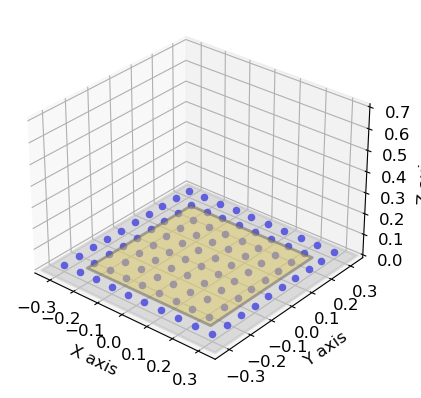

In [3]:
# Loading pre-computed
field_array = PistonOnBaffle()
field_array.load('pob_arraycase')
field_array.add_noise(snr = 30)
field_array.plot_scene(vsam_size = 0.7)

## Avaliando o que medimos

Note que a pressão sonora medida tem dimensão $M \times N_f$, em que $N_f$ é o número de frequências simuladas. 

In [4]:
print("frequency vector: {} Hz.".format(field_array.controls.freq))
print("Shape of coordinates: {}.".format(field_array.receivers.coord.shape))
print("Shape of Sound pressure: {}.".format(field_array.pres_s.shape))

frequency vector: [ 800 1000 2000] Hz.
Shape of coordinates: (100, 3).
Shape of Sound pressure: (100, 3).


# Decomposição em ondas planas prop. e evan. (Quais são os passos?)

#### 1. Você possui $M$ medições nas coordenadas $\textbf{r}_1, \cdots, \textbf{r}_M$; 

\begin{equation}
\textbf{p} = \textbf{H x} + \textbf{n}
\end{equation}

#### 2. Grid $k_x \times k_y$

Você deve criar um grid $k_x \times k_y$ contendo suas ondas **propagantes** e **evanescentes**. É usual que o grid varra $k_x$  entre $\pm \pi/\Delta_x$ (e $k_y$ entre $\pm  \pi/\Delta_y$). $\Delta_x$ e $\Delta_y$ são os espaçamentos médios (mínimos ou máximos) entre os microfones. A resolução no domínio de número de onda é **"arbitrária"**. No entanto, você deve ter cuidado pra não ficar com um problema grande demais (ou retangular demais), ou com uma matriz $\textbf{H}$ com colunas correlacionadas.

#### 3. Forme $k_z$:

\begin{equation}
k_z = \begin{cases} \sqrt{k_0^2-(k_{x}^{2}+k_{y}^{2})}, & \mbox{se  }  k_{x}^{2}+k_{y}^{2} \leq k_0^2 \\ -\text{j} \sqrt{(k_{x}^{2}+k_{y}^{2})-k_0^2}, & \mbox{se }  k_{x}^{2}+k_{y}^{2} > k_0^2 \end{cases}
\end{equation}

Note que $k_z$ será uma esfera com valores positivos para $k_{x}^{2}+k_{y}^{2} \leq k_0^2$ (**ondas propagantes**); Para as **ondas evanescentes** ($k_{x}^{2}+k_{y}^{2} > k_0^2$), a pressão sonora decai na direção $z>0$ e  (para problemas de **radiação sonora**).

#### 4. Kernel: 

Na formulação SONAH (de acordo com Hald): cada elemento de nossa matriz é

\begin{equation}
\Psi(\textbf{k},\textbf{r}) = \sqrt{\frac{\Delta k_x \Delta k_y}{2\pi k_0^2}} \ F_0 \sqrt{\frac{k_0}{k_z}} \ \text{e}^{-\text{j}(k_x x_m + k_y y_m + k_z (z_m-z_{\text{sp}}))}
\end{equation}
em que $z_{\text{sp}}$ é a localização do **source plane**. Este é um híper-parâmetro da nossa inferência, mas é muito importante pra regularizar bem o problema. Pense que se você quer reconstruir a vibração da fonte, não é bom que as ondas comecem a decair exatamente dela - já que vão aumentar de valor no processo de reconstrução. Dar uma localização do **source plane** atrás da fonte real, ajuda a manter a reconstrução em cheque. O primeiro termo após a igualdade existe para tornar a transição do espectro contínuo ao discreto mais suave (não é uma coisa tão primordial). Já o termo $F_0 \sqrt{\frac{k_0}{k_z}}$ extiste para compensar o fato de que ao criar um grid $k_x \times k_y$ **regular**, você vai terminar com mais pontos nos polos que no equador (**dentro do círculo de radiação**). O termo ajuda a equilibrar isso.

#### 4. Matriz $\textbf{H}$ ($M \times L$): 

\begin{equation}
\textbf{H} =
\begin{bmatrix}
\Psi(\textbf{k}_1,\textbf{r}_1) & \Psi(\textbf{k}_2,\textbf{r}_1) & \ldots & \Psi(\textbf{k}_L,\textbf{r}_1)\\
\Psi(\textbf{k}_1,\textbf{r}_2) & \Psi(\textbf{k}_2,\textbf{r}_2) & \ldots & \Psi(\textbf{k}_L,\textbf{r}_2)\\
\vdots & \vdots & \ddots & \vdots \\
\Psi(\textbf{k}_1,\textbf{r}_M) & \Psi(\textbf{k}_2,\textbf{r}_M) & \ldots & \Psi(\textbf{k}_L,\textbf{r}_M)\\
\end{bmatrix}
\end{equation}

#### 5. Computar o SVD da matriz 

\begin{equation}
\textbf{H} = \textbf{U}\Sigma\textbf{V}^H
\end{equation}

#### 6. Usar o SVD e o vetor $\textbf{p}$ (dados medidos) para computar um parâmetro de regularização, $\lambda$.

#### 7. Computar a solução regularizada

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

#### 8. Reconstrução e análise

# Montando o problema do zero (para uma frequência)

#### 1. Você possui $M$ medições nas coordenadas $\textbf{r}_1, \cdots, \textbf{r}_M$;

In [49]:
# Getting the data ready
index = 1
freq = field_array.controls.freq[index]
print(r'freq = {0:.2f} Hz'.format(freq))

k0 = 2*np.pi*freq / field_array.controls.c0
print(r'k0 = {0:.2f} rad/s'.format(k0))
# Receptores
r_vecs = field_array.receivers.coord
print('shape da matriz de receptores: {}'.format(r_vecs.shape))
Dx = field_array.receivers.ax
Dy = field_array.receivers.ay
print('espaçamento entre sensores: {} m (x), {} m (y)'.format(Dx, Dy))
# Dados medidos (com algum ruído)
pres = field_array.pres_s[:, index]
print('shape da matriz de pressão: {}'.format(pres.shape))

freq = 1000.00 Hz
k0 = 18.48 rad/s
shape da matriz de receptores: (100, 3)
espaçamento entre sensores: 0.06 m (x), 0.06 m (y)
shape da matriz de pressão: (100,)


#### 2. Grid $k_x \times k_y$

In [50]:
# 2 k_x vs. k_y grid
# (resolution)
n_k = 60
# (linspace)
kx = np.linspace(start = -np.pi/Dx, stop = np.pi/Dx, num = n_k)
ky = np.linspace(start = -np.pi/Dy, stop = np.pi/Dy, num = n_k)
# (k-space resolution) 
delta_kx = kx[1] - kx[0]
delta_ky = ky[1] - ky[0]
# meshgrid
kx_grid, ky_grid = np.meshgrid(kx,ky)
# flatten
kx_f = kx_grid.flatten()
ky_f = ky_grid.flatten()

print(r' Temos {} ondas planas no problema'.format(kx_f.shape))

 Temos (3600,) ondas planas no problema


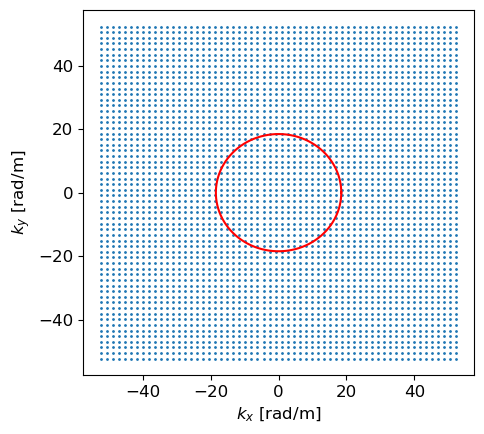

In [51]:
fig = plt.figure(figsize = (5,4.5))
plt.plot(kx_f, ky_f, 'o', markersize = 1)
plt.plot(k0*np.cos(np.arange(0, 2*np.pi+0.01, 0.01)),
    k0*np.sin(np.arange(0, 2*np.pi+0.01, 0.01)), 'r')
plt.xlabel(r'$k_x$ [rad/m]')
plt.ylabel(r'$k_y$ [rad/m]')
plt.tight_layout()

#### 3. Forme $k_z$:

In [35]:
# Forme k_z
# (kx**2 + ky**2)
ke_norm = (kx_f**2 + ky_f**2)**0.5
kz_f = np.zeros(len(kx_f), dtype = complex)
# propagating part
idp = np.where(ke_norm <= k0)[0]
kz_f[idp] = np.sqrt(k0**2 - (kx_f[idp]**2+ky_f[idp]**2))
# evanescent part
ide = np.where(ke_norm > k0)[0]
kz_f[ide] = -1j*np.sqrt(kx_f[ide]**2+ky_f[ide]**2-k0**2)

In [23]:
print(kz_f)

[ 0.        -71.70498416j  0.        -69.11221672j
  0.        -66.61434729j  0.        -64.22244971j
  0.        -61.94880022j  0.        -59.80688645j
  0.        -57.81135273j  0.        -55.97785597j
  0.        -54.32280583j  0.        -52.86296552j
  0.        -51.61490127j  0.        -50.59428783j
  0.        -49.81510722j  0.        -49.28881081j
  0.        -49.02354386j  0.        -49.02354386j
  0.        -49.28881081j  0.        -49.81510722j
  0.        -50.59428783j  0.        -51.61490127j
  0.        -52.86296552j  0.        -54.32280583j
  0.        -55.97785597j  0.        -57.81135273j
  0.        -59.80688645j  0.        -61.94880022j
  0.        -64.22244971j  0.        -66.61434729j
  0.        -69.11221672j  0.        -71.70498416j
  0.        -69.11221672j  0.        -66.41831258j
  0.        -63.81508451j  0.        -61.31408316j
  0.        -58.92832591j  0.        -56.67236905j
  0.        -54.5623153j   0.        -52.61572109j
  0.        -50.85136163j  0.  

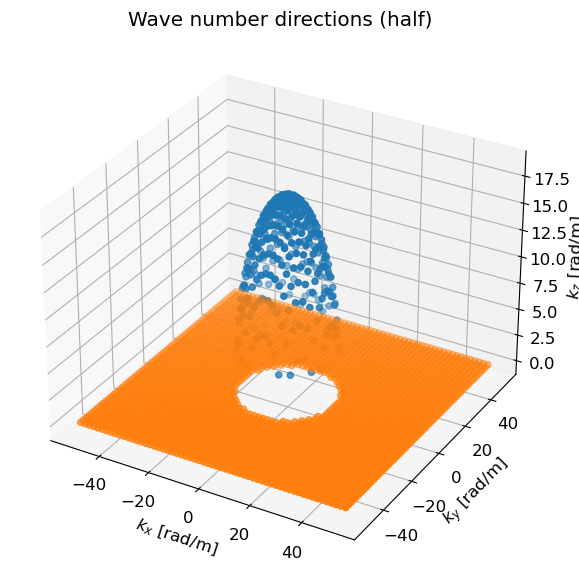

In [36]:
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")
ax.scatter(kx_f[idp], ky_f[idp], np.real(kz_f[idp]))
ax.scatter(kx_f[ide], ky_f[ide])
ax.set_xlabel(r'$k_x$ [rad/m]')
ax.set_ylabel(r'$k_y$ [rad/m]')
ax.set_zlabel(r'$k_z$ [rad/m]')
plt.title('Wave number directions (half)')
plt.tight_layout()
plt.show()

#### 4. Kernel

O que seria uma boa ideia para a localização do **source plane**? 

- Se você colocar o **source plane** muito atraz da sua fonte real, fará com que as ondas evanescentes no seu modelo tenham decaído nos microfones (como se o seu **source plane** estivesse muito longe do ponto de medição). O problema tende a ficar sobre-regularizado porque é **como se houvessem apenas ondas propagantes**.

A literatura indica que:

\begin{equation}
z_{sp} = \epsilon \ \text{max}(\Delta_x, \Delta_y), \ \ \  \text{com} \ \ \ 1.0 \leq \epsilon \leq 2.5
\end{equation}

In [37]:
# Kernel e Matriz
k_vec = np.array([kx_f, ky_f, kz_f])
kappa = np.sqrt(delta_kx*delta_ky/(2*np.pi*k0**2))
fz_ref = 1.0 * np.sqrt(k0/np.abs(kz_f)) # compensate for higher density near the poles (propagating)

# source plane
zp = -1.0*np.amax([Dx,Dy])
recs = np.array([r_vecs[:,0], r_vecs[:,1], r_vecs[:,2]-zp]).T

# kernel e  matriz
H = fz_ref * kappa * np.exp(-1j * recs @ k_vec)
print("shape de H: {}".format(H.shape))

shape de H: (100, 3600)


#### 5. Computar o SVD

shape da matriz U: (100, 100)
shape da matriz Sigma: (100,)
shape da matriz V^T: (100, 3600)


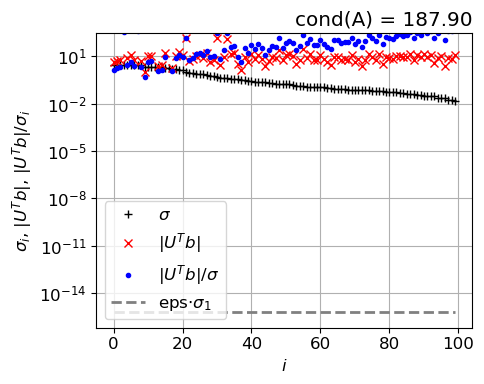

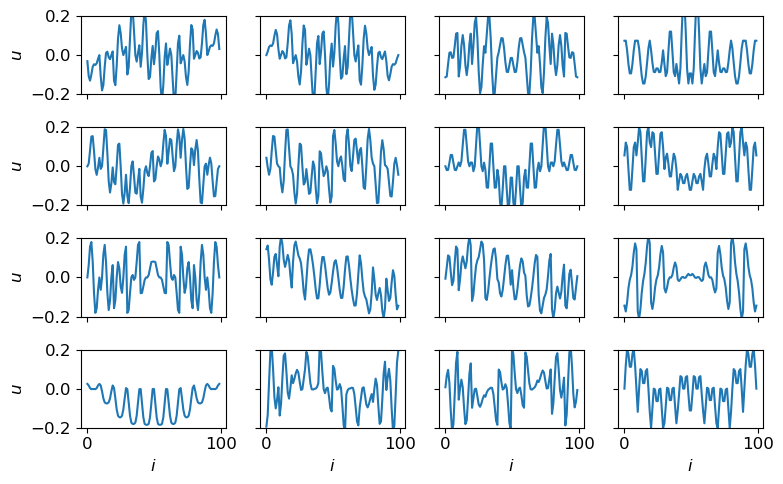

In [38]:
# SVD
[U,s,V] = lc.csvd(H)
print('shape da matriz U: {}'.format(U.shape))
print(r'shape da matriz Sigma: {}'.format(s.shape))
print(r'shape da matriz V^T: {}'.format(V.T.shape))
# plot Picard
lc.plot_picard(U,s,pres)
# plot column vectors
lc.plot_colvecs(np.real(U))

# GCV

Compute o parâmetro de regularização por GCV e então a solução de Tikhonov

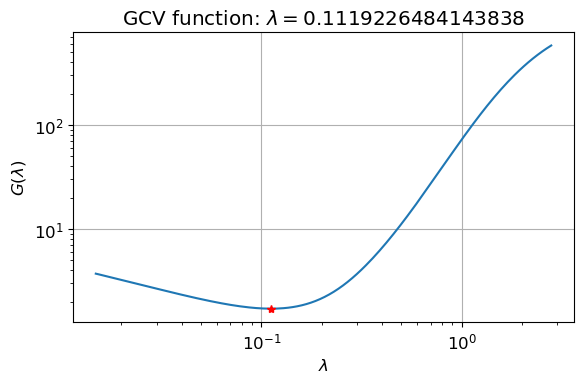

In [39]:
lam_gcv = lc.gcv_lambda(U, s, pres, print_gcvfun = True)
x_gcv = lc.tikhonov(U, s, V, pres, lam_gcv)

# L-curve

Compute o parâmetro de regularização por L-curve e então a solução de Tikhonov

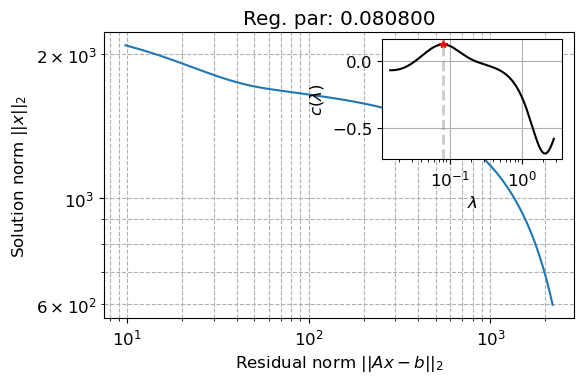

In [40]:
lam_lc = lc.l_curve(U, s, pres, plotit = True)
x_lc = lc.tikhonov(U, s, V, pres, lam_lc[0])

# Plot a result 

ok, it does look like a bad video-game or something that gradma sewed. But, not so bad...

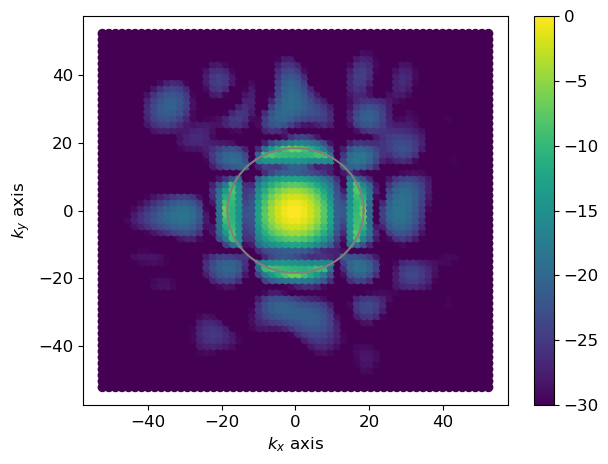

In [41]:
dinrange = 30
sol = x_lc # x_gcv
color_par = 20*np.log10(np.abs(sol)/np.amax(np.abs(sol)))
id_outofrange = np.where(color_par < -dinrange)
color_par[id_outofrange] = -dinrange
vmin = -dinrange
vmax = 0

fig = plt.figure()
plt.plot(k0*np.cos(np.arange(0, 2*np.pi+0.01, 0.01)), k0*np.sin(np.arange(0, 2*np.pi+0.01, 0.01)), 'Gray')
pp = plt.scatter(kx_f, ky_f, c = color_par, vmin = vmin, vmax = vmax)
fig.colorbar(pp)
plt.xlabel(r'$k_x$ axis')
plt.ylabel(r'$k_y$ axis')
plt.tight_layout()

# Vamos lembrar da solução analítica


Para o caso do pistão quadrado com velocidade constante, podemos escrever:

\begin{equation}
    v(x^{'}, y^{'}, 0) = \begin{cases}
      1 \ \ \ \ \text{para} \ \ \ \ \frac{-L}{2} \leq x^{'} \leq \frac{L}{2} \ \ \ \ \& \ \ \ \ \frac{-L}{2} \leq y^{'} \leq \frac{-L}{2} \\
      0 \ \ \ \  \text{caso contrário}
    \end{cases}\
\end{equation}

com Transformada Espacial de Fourier

\begin{equation}
    V(k_x, k_y, 0) = L^2 \text{sinc}\left(k_x \frac{L}{2}\right) \ \text{sinc}\left(k_y \frac{L}{2}\right)
\end{equation}

Vamos plotar este espectro. Lembre-se $k_z$ depende de $k_x$ e $k_y$

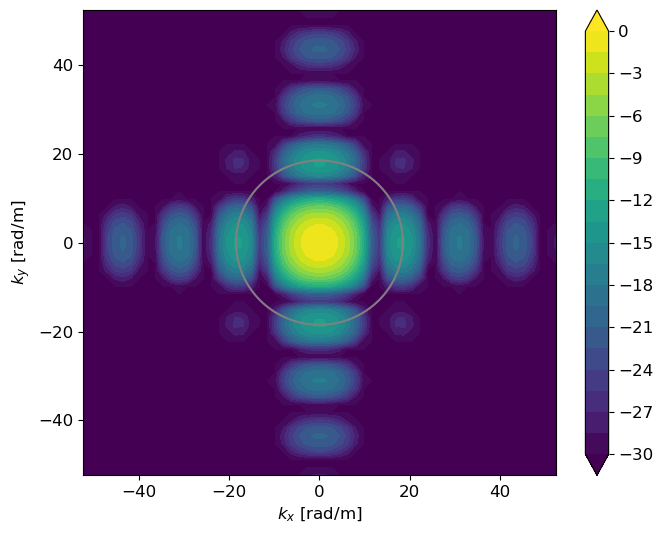

In [55]:
V_kx_ky = (L**2)*np.sinc(kx_grid * L/(2*np.pi))*np.sinc(ky_grid * L/(2*np.pi))

dinrange = 30
color_par = 20*np.log10(np.abs(V_kx_ky)/np.amax(np.abs(V_kx_ky)))
id_outofrange = np.where(color_par < -dinrange)
color_par[id_outofrange] = -dinrange
color_range = np.linspace(-dinrange, 0, 21)

fig = plt.figure(figsize=(7, 5.5))
plt.plot(k0*np.cos(np.arange(0, 2*np.pi+0.01, 0.01)), k0*np.sin(np.arange(0, 2*np.pi+0.01, 0.01)), 'Gray')
p = plt.contourf(kx_grid, ky_grid, color_par, color_range, extend='both', cmap = 'viridis')
fig.colorbar(p,ticks=np.arange(-dinrange, 3, 3))
plt.xlabel(r'$k_x$ [rad/m]')
plt.ylabel(r'$k_y$ [rad/m]')
plt.tight_layout();

# Going pro

O que quero dizer com isso é que você pode programar tudo de forma organizada e ter escolhas como o tipo de regularização, escolha automática do parâmetro de regularização, plots das informações, reconstrução, etc. Assim, tudo fica organizado e você consegue fazer as coisas com boa repetibilidade. 

Há algo que eu gosto de fazer com o grid de ondas planas. No grid original:

- o número de ondas planas dentro do círculo de radiação aumenta com a frequência (mas **em algumas freqûencias**, você pode ficar com um **número muito pequeno** de ondas planas **propagantes**);
- Há mais ondas planas nos polos e é preciso compensar por isso, o que acaba **descompensando** um pouco as evanescentes.
- Também suspeito que as vezes você **não tem componentes propagantes tangenciais suficientes**. Isso faz com que você salte muito rápido para as evanescentes ou que infira altas magnitudes exatamente onde possui componentes. Isso tende a causar problemas de inferência exatamente em cima de $k_0$.

O que proponho é:

1. Forme um grid de ondas propagantes com base na amostragem de uma hemisfera (**equiangular** como no problema do espectro angular)
2. Forme o grid $k_x \times k_y$ da maneira usual tentando equilibrar o número de pontos na hemisfera e no restante do grid (evanescentes)
3. Substitua o grid de ondas propagantes em "2" pelo grid gerado em "1". 

Um grid típico gerado para 1000 Hz tem a seguinte aparência:


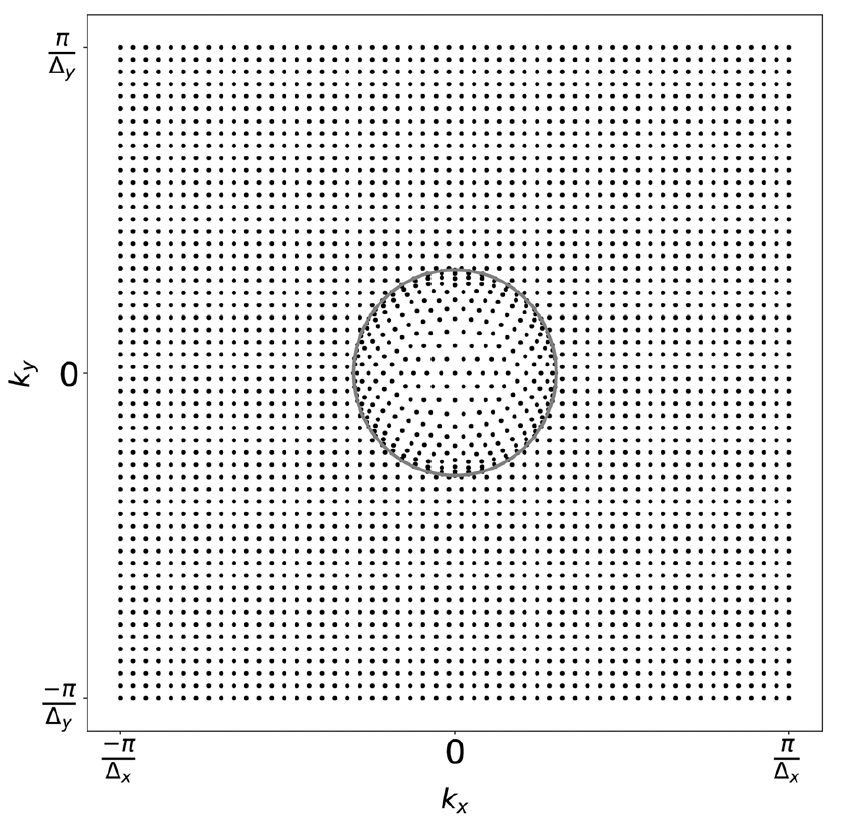

You choose L-curve to find optimal regularization parameter


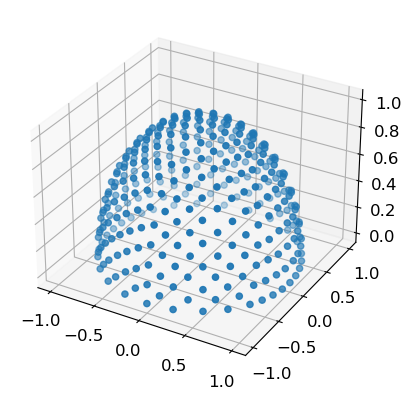

In [52]:
pk = DecompositionEv2(p_mtx = field_array.pres_s, controls = field_array.controls, 
                     receivers = field_array.receivers, regu_par = 'l-curve')
pk.prop_dir(n_waves = 642, plot = True)

In [53]:
pk.pk_tikhonov_ev_ig(f_ref=1, f_inc=1, factor=1, zref = 0.0, plot_l=False, method = 'Tikhonov')

Calculating Tikhonov inversion (with evanescent waves and irregular grid)...: 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


# O que vemos ao plotar o espectro do número de onda?

Lembre-se de comparar com a solução analítica.

- Os espectros são similares, mas não iguais.
- Há algumas componentes espúrias no espectro estimado.
- Em geral, as ondas evanescentes de **maior frequência espacial** tendem a ser sobre-regularizadas, já que são elas as componentes mais contaminadas por ruído.

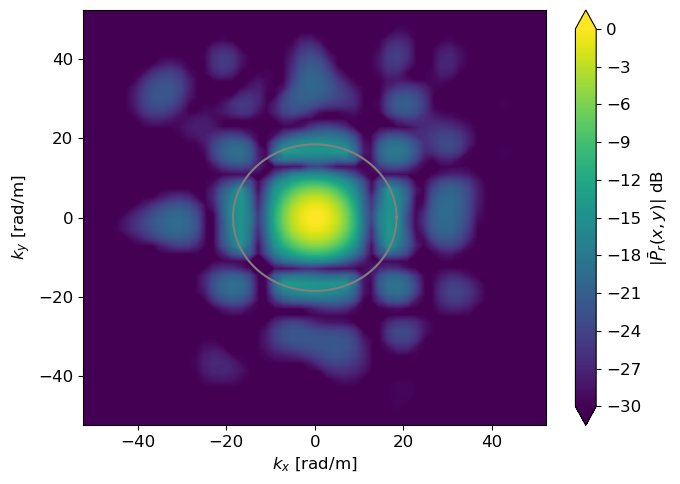

In [54]:
pk.plot_pkmap_v2(freq = 1000, db = True, plot_incident = False, dinrange = 30, color_code='viridis', figsize = (7,5))

In [57]:
pk.lambd_value_vec

array([2.56252325, 2.61183095, 1.33989685])

# Direcionalidade

Você também pode inferir a direcionalidade a partir de medições tomadas bem próximas do objeto vibrante. Note que isto é feito, em geral, a partir de medições muito distantes do objeto de medição (O que pode ser inviável).

In [65]:
idf = 2
freq = pk.controls.freq[idf]
print("Frequency is {} Hz".format(freq))

fig, trace = pk.plot_directivity(freq = freq, dinrange = 40, color_code = 'jet', true_directivity = False)
fig.show()

Frequency is 2000 Hz


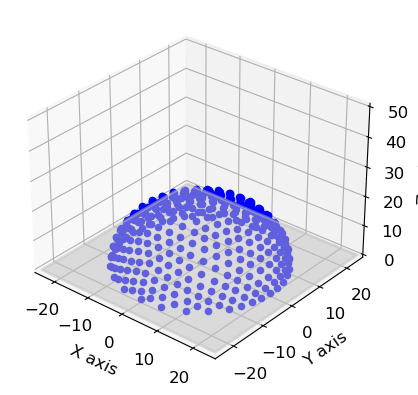

In [63]:
# Loading pre-computed
field_sph = PistonOnBaffle()
field_sph.load('pob_sphericalcase')
field_sph.plot_scene(vsam_size = 50)

In [66]:
fig, trace = plot_3d_polar(field_sph.receivers.coord, field_sph.receivers.conectivities, field_sph.pres_s[:,idf], dinrange = 40,
                  color_method = 'dB', radius_method = 'dB', color_code = 'jet', view = 'iso_z', eye = None,
                  renderer = 'notebook', remove_axis = False)
fig.show()

# Reconstrução

- Vamos carregar o campo de referência (pré-computado)

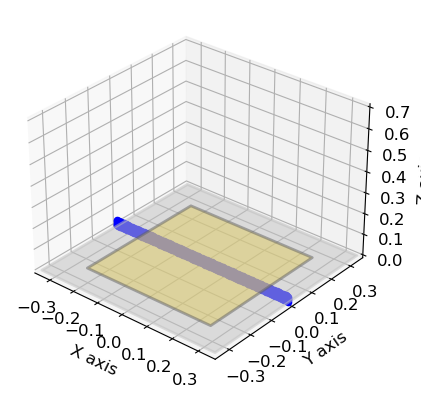

In [67]:
# Loading pre-computed
field_recon_array = PistonOnBaffle()
field_recon_array.load('pob_reconarraycase')
field_recon_array.plot_scene(vsam_size = 0.7)

- Vamos reconstruir o campo acústico a partir da decomposição

In [68]:
# Reconstrução
pk.reconstruct_pu(field_recon_array.receivers)
print("Shape of reconstructed pressure is {}".format(pk.p_recon.shape))

Reconstructing sound field...: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

Shape of reconstructed pressure is (700, 3)


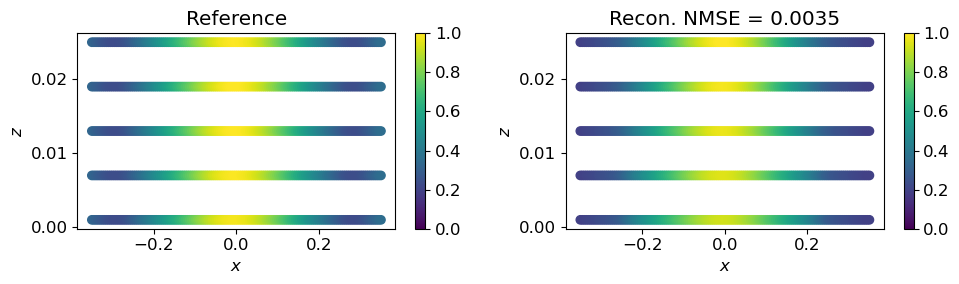

In [121]:
idf = 1

color_par1 = np.abs(pk.p_recon[:,idf])/np.amax(np.abs(pk.p_recon[:,idf]))
color_par2 = np.abs(field_recon_array.pres_s[:,idf])/np.amax(np.abs(field_recon_array.pres_s[:,idf]))

NMSE = lc.nmse(np.abs(pk.p_recon[:,idf]), np.abs(field_recon_array.pres_s[:,idf]))

fig, axs = plt.subplots(1, 2, figsize = (10,3))
pp = axs[0].scatter(field_recon_array.receivers.coord[:,0], field_recon_array.receivers.coord[:,2], c = color_par1,
                   vmin = 0, vmax = 1)
fig.colorbar(pp)
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$z$')
axs[0].set_title(r'Reference')

pp = axs[1].scatter(field_recon_array.receivers.coord[:,0], field_recon_array.receivers.coord[:,2], c = color_par2,
                   vmin = 0, vmax = 1)
fig.colorbar(pp)
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$z$')
axs[1].set_title(r'Recon. NMSE = {:.4f}'.format(NMSE))
plt.tight_layout()

# Sound intensity

In [122]:
Ix = 0.5*np.real(pk.p_recon[:,idf] * np.conj(pk.ux_recon[:,idf]))
Iz = 0.5*np.real(pk.p_recon[:,idf] * np.conj(pk.uz_recon[:,idf]))
I = np.sqrt(Ix**2 + Iz**2)

(-0.4, 0.4)

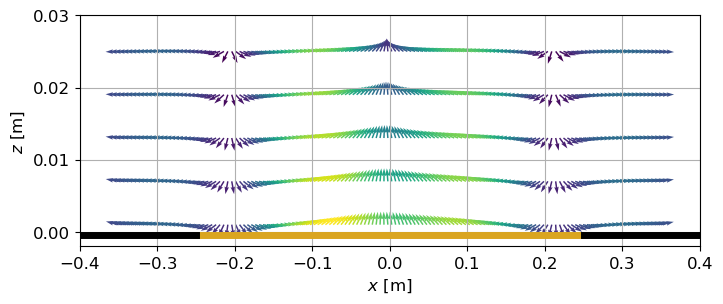

In [123]:
plt.figure(figsize = (8,3))
plt.quiver(field_recon_array.receivers.coord[:, 0], field_recon_array.receivers.coord[:, 2], Ix/I, Iz/I, I)
plt.plot(np.linspace(-L/2, L/2, 1000), -0.0005*np.ones(1000), linewidth = 5, color = 'goldenrod')
plt.plot(np.linspace(L/2, 1, 1000), -0.0005*np.ones(1000), linewidth = 5, color = 'black')
plt.plot(np.linspace(-1, -L/2, 1000), -0.0005*np.ones(1000), linewidth = 5, color = 'black')
plt.grid()
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$z$ [m]")
plt.ylim((-0.002, 0.03))
plt.xlim((-0.4, 0.4))

In [ ]:
import scipy.io
file_path = 'sonah_pk.mat'
scipy.io.savemat(file_path, {'r_vecs': r_vecs,                           
                            'freq': controls.freq,
                             'k0' : controls.k0,
                            'p': field_array.pres_s,
                            'Upy' : U,
                            'spy' : s,
                            'Vpy' : V,
                            'Hpy' : H})